# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

VGG16 Parameters: 553MB [16:57, 544KB/s]                                


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [2]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

Flowers Dataset: 229MB [00:44, 5.11MB/s]                              


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [2]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [3]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

Below I'm running images through the VGG network in batches.

> **Exercise:** Below, build the VGG network. Also get the codes from the first fully connected layer (make sure you get the ReLUd values).

In [5]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 100
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
    # TODO: Build the vgg network here

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                codes_batch = sess.run(vgg.relu6, feed_dict={input_: images})
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/WORKSPACE/scott.quiring/MachineLearning/DeepLearning/Projects/newCheckout/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting roses images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
641 images processed
Starting sunflowers images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
699 images processed
Starting tulips images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
799 images processed
Starting daisy images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
633 images processed
Starting dandelion images
100 images processed
200 images processed
300 images processed
400 images

In [6]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [4]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [5]:
import sklearn
import sklearn.preprocessing
import sklearn.model_selection

In [6]:
labels

array(['roses', 'roses', 'roses', ..., 'dandelion', 'dandelion',
       'dandelion'],
      dtype='<U10')

In [7]:
binarizer = sklearn.preprocessing.LabelBinarizer()# Your one-hot encoded labels array here
binarizer.fit(labels)
labels_vecs = binarizer.transform(labels)
labels_vecs

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ..., 
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [23]:
binarizer.classes_

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [18]:
ss_1 = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=.2)
train_idxs, test_idxs = next(ss_1.split(codes, labels))
train_x, train_y = codes[train_idxs,:], labels_vecs[train_idxs,:]
test_x, test_y = codes[test_idxs, :], labels_vecs[test_idxs,:]

In [19]:
ss_2 = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=.5)
val_idxs, test_idxs = next(ss_2.split(test_x, test_y))
val_x, val_y = test_x[val_idxs,:], test_y[val_idxs,:]
test_x, test_y = test_x[test_idxs,:], test_y[test_idxs,:]

In [20]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [117]:
graph = tf.Graph()

with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
    labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

    # TODO: Classifier layers and operations

    with tf.variable_scope('fc1') as scope:
        weights = tf.Variable(
            tf.truncated_normal(shape=[int(inputs_.shape[1]), 256], stddev=0.01),
            name='weights')
        biases = tf.Variable(tf.zeros([weights.shape[1]]), name='biases')
        fc1 = tf.nn.relu(tf.matmul(inputs_, weights) + biases, name=scope.name)
        
    with tf.variable_scope('fc2') as scope:
        weights = tf.Variable(tf.truncated_normal([int(fc1.shape[1]), 5], stddev=0.01),
                              name='weights')
        biases = tf.Variable(tf.zeros([weights.shape[1]]), name='biases')
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases, name=scope.name)
        
#     with tf.variable_scope('fc3') as scope:
#         weights = tf.Variable(tf.truncated_normal([int(fc2.shape[1]), 5], stddev=0.01),
#                               name='weights')
#         biases = tf.Variable(tf.zeros([weights.shape[1]]), name='biases')
#         fc3 = tf.nn.relu(tf.matmul(fc2, weights) + biases, name=scope.name)

    logits = fc2 # output layer logits
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits))# cross entropy loss
    tf.summary.scalar('cost', cost)

    optimizer = tf.train.AdamOptimizer().minimize(cost)# training optimizer

    # Operations for validation/test accuracy
    predicted = tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [118]:
cost.shape

TensorShape([])

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [119]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [120]:
run_number = 0
completed_training = False

In [121]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

In [122]:
merged_summary.shape

TensorShape([])

In [123]:

with graph.as_default():
    merged_summary = tf.summary.merge_all()
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()

Epoch 0/40 Batch 4/10 Iteration 5 Training loss: 0.808
Epoch 0/40 Batch 9/10 Iteration 10 Training loss: 0.706
Epoch 1/40 Batch 4/10 Iteration 15 Training loss: 0.544
Epoch 1/40 Batch 9/10 Iteration 20 Training loss: 0.555
Epoch 2/40 Batch 4/10 Iteration 25 Training loss: 0.480
Valiation accuracy: 67.302448%


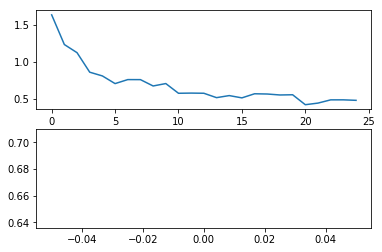

Epoch 2/40 Batch 9/10 Iteration 30 Training loss: 0.486
Epoch 3/40 Batch 4/10 Iteration 35 Training loss: 0.429
Epoch 3/40 Batch 9/10 Iteration 40 Training loss: 0.416
Epoch 4/40 Batch 4/10 Iteration 45 Training loss: 0.417
Epoch 4/40 Batch 9/10 Iteration 50 Training loss: 0.400
Valiation accuracy: 69.482279%


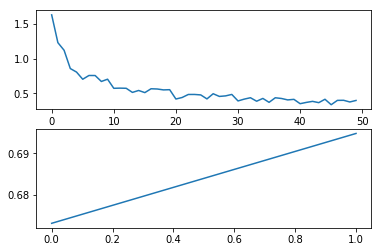

Epoch 5/40 Batch 4/10 Iteration 55 Training loss: 0.395
Epoch 5/40 Batch 9/10 Iteration 60 Training loss: 0.361
Epoch 6/40 Batch 4/10 Iteration 65 Training loss: 0.374
Epoch 6/40 Batch 9/10 Iteration 70 Training loss: 0.353
Epoch 7/40 Batch 4/10 Iteration 75 Training loss: 0.383
Valiation accuracy: 68.664849%


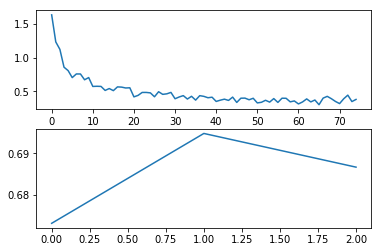

Epoch 7/40 Batch 9/10 Iteration 80 Training loss: 0.382
Epoch 8/40 Batch 4/10 Iteration 85 Training loss: 0.376
Epoch 8/40 Batch 9/10 Iteration 90 Training loss: 0.458
Epoch 9/40 Batch 4/10 Iteration 95 Training loss: 0.413
Epoch 9/40 Batch 9/10 Iteration 100 Training loss: 0.364
Valiation accuracy: 67.574924%


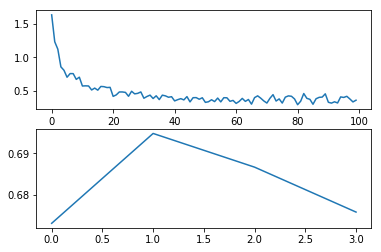

Epoch 10/40 Batch 4/10 Iteration 105 Training loss: 0.369
Epoch 10/40 Batch 9/10 Iteration 110 Training loss: 0.349
Epoch 11/40 Batch 4/10 Iteration 115 Training loss: 0.361
Epoch 11/40 Batch 9/10 Iteration 120 Training loss: 0.335
Epoch 12/40 Batch 4/10 Iteration 125 Training loss: 0.359
Valiation accuracy: 70.027244%


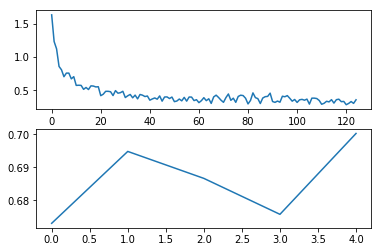

Epoch 12/40 Batch 9/10 Iteration 130 Training loss: 0.325
Epoch 13/40 Batch 4/10 Iteration 135 Training loss: 0.354
Epoch 13/40 Batch 9/10 Iteration 140 Training loss: 0.320
Epoch 14/40 Batch 4/10 Iteration 145 Training loss: 0.353
Epoch 14/40 Batch 9/10 Iteration 150 Training loss: 0.317
Valiation accuracy: 67.847407%


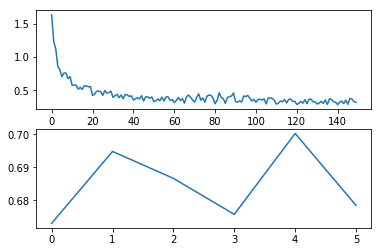

Epoch 15/40 Batch 4/10 Iteration 155 Training loss: 0.351
Epoch 15/40 Batch 9/10 Iteration 160 Training loss: 0.315
Epoch 16/40 Batch 4/10 Iteration 165 Training loss: 0.354
Epoch 16/40 Batch 9/10 Iteration 170 Training loss: 0.321
Epoch 17/40 Batch 4/10 Iteration 175 Training loss: 0.349
Valiation accuracy: 69.754767%


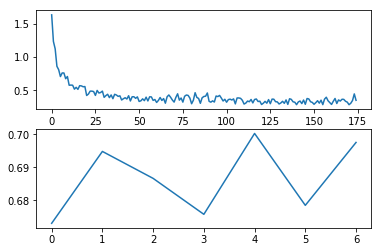

Epoch 17/40 Batch 9/10 Iteration 180 Training loss: 0.321
Epoch 18/40 Batch 4/10 Iteration 185 Training loss: 0.386
Epoch 18/40 Batch 9/10 Iteration 190 Training loss: 0.331
Epoch 19/40 Batch 4/10 Iteration 195 Training loss: 0.411
Epoch 19/40 Batch 9/10 Iteration 200 Training loss: 0.491
Valiation accuracy: 70.299721%


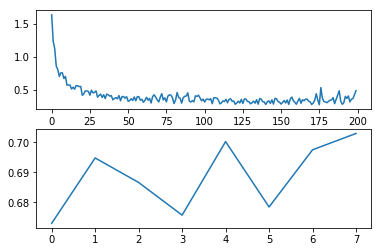

Epoch 20/40 Batch 4/10 Iteration 205 Training loss: 0.453
Epoch 20/40 Batch 9/10 Iteration 210 Training loss: 0.525
Epoch 21/40 Batch 4/10 Iteration 215 Training loss: 0.379
Epoch 21/40 Batch 9/10 Iteration 220 Training loss: 0.371
Epoch 22/40 Batch 4/10 Iteration 225 Training loss: 0.386
Valiation accuracy: 67.029971%


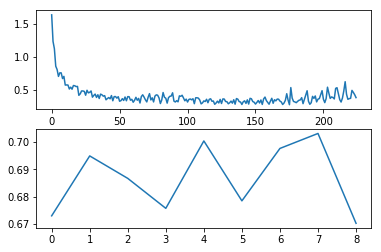

Epoch 22/40 Batch 9/10 Iteration 230 Training loss: 0.454
Epoch 23/40 Batch 4/10 Iteration 235 Training loss: 0.443
Epoch 23/40 Batch 9/10 Iteration 240 Training loss: 0.317
Epoch 24/40 Batch 4/10 Iteration 245 Training loss: 0.346
Epoch 24/40 Batch 9/10 Iteration 250 Training loss: 0.320
Valiation accuracy: 70.572203%


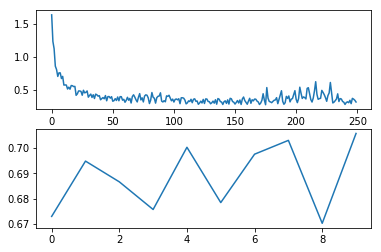

Epoch 25/40 Batch 4/10 Iteration 255 Training loss: 0.343
Epoch 25/40 Batch 9/10 Iteration 260 Training loss: 0.315
Epoch 26/40 Batch 4/10 Iteration 265 Training loss: 0.343
Epoch 26/40 Batch 9/10 Iteration 270 Training loss: 0.313
Epoch 27/40 Batch 4/10 Iteration 275 Training loss: 0.342
Valiation accuracy: 69.754767%


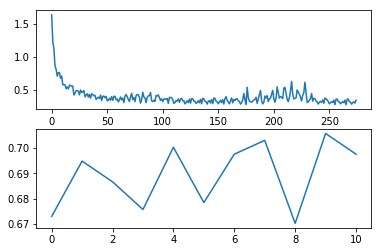

Epoch 27/40 Batch 9/10 Iteration 280 Training loss: 0.313
Epoch 28/40 Batch 4/10 Iteration 285 Training loss: 0.341
Epoch 28/40 Batch 9/10 Iteration 290 Training loss: 0.313
Epoch 29/40 Batch 4/10 Iteration 295 Training loss: 0.341
Epoch 29/40 Batch 9/10 Iteration 300 Training loss: 0.313
Valiation accuracy: 70.027250%


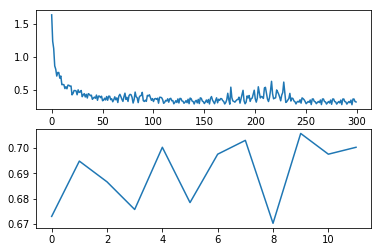

Epoch 30/40 Batch 4/10 Iteration 305 Training loss: 0.341
Epoch 30/40 Batch 9/10 Iteration 310 Training loss: 0.313
Epoch 31/40 Batch 4/10 Iteration 315 Training loss: 0.341
Epoch 31/40 Batch 9/10 Iteration 320 Training loss: 0.313
Epoch 32/40 Batch 4/10 Iteration 325 Training loss: 0.341
Valiation accuracy: 70.572203%


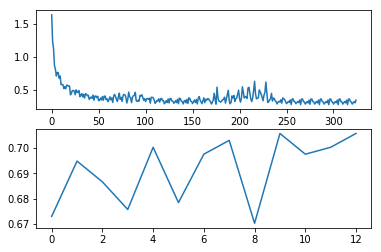

Epoch 32/40 Batch 9/10 Iteration 330 Training loss: 0.313
Epoch 33/40 Batch 4/10 Iteration 335 Training loss: 0.341
Epoch 33/40 Batch 9/10 Iteration 340 Training loss: 0.313
Epoch 34/40 Batch 4/10 Iteration 345 Training loss: 0.341
Epoch 34/40 Batch 9/10 Iteration 350 Training loss: 0.313
Valiation accuracy: 70.027250%


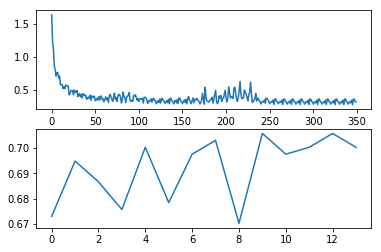

Epoch 35/40 Batch 4/10 Iteration 355 Training loss: 0.341
Epoch 35/40 Batch 9/10 Iteration 360 Training loss: 0.313
Epoch 36/40 Batch 4/10 Iteration 365 Training loss: 0.341
Epoch 36/40 Batch 9/10 Iteration 370 Training loss: 0.313
Epoch 37/40 Batch 4/10 Iteration 375 Training loss: 0.341
Valiation accuracy: 70.027244%


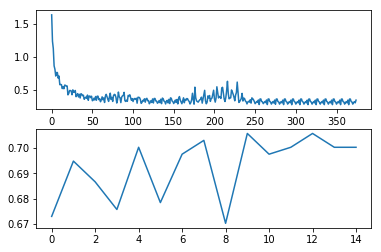

Epoch 37/40 Batch 9/10 Iteration 380 Training loss: 0.313
Epoch 38/40 Batch 4/10 Iteration 385 Training loss: 0.341
Epoch 38/40 Batch 9/10 Iteration 390 Training loss: 0.313
Epoch 39/40 Batch 4/10 Iteration 395 Training loss: 0.341
Epoch 39/40 Batch 9/10 Iteration 400 Training loss: 0.312
Valiation accuracy: 69.482285%


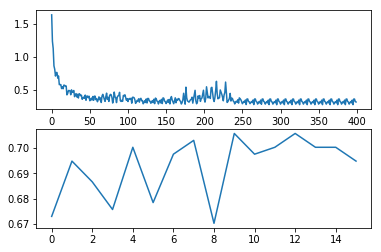

In [124]:
#saver = tf.train.Saver()
n_epochs = 40
n_batches = 10
continue_training = False
if not continue_training:
    if completed_training:
        run_number += 1
    losses = []
    accuracies = []


with tf.Session(graph=graph) as sess:
    completed_training = False
    if continue_training:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    else:
        sess.run(init)
    
    train_writer = tf.summary.FileWriter('./logs/{}/train'.format(run_number))
    val_writer   = tf.summary.FileWriter('./logs/{}/val'.format(run_number))
    
    iteration = 1
    for e in range(n_epochs):
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, n_batches)):
            feed = {inputs_: x,
                    labels_: y}
            summary, loss, train_acc, _ = sess.run([merged_summary, cost, accuracy, optimizer],
                                        feed_dict=feed)
            train_writer.add_summary(summary, iteration)
            losses.append(loss)
            
            if iteration%5 == 0:
                print('Epoch {}/{}'.format(e, n_epochs),
                      'Batch {}/{}'.format(ii,n_batches),
                      'Iteration {}'.format(iteration),
                      'Training loss: {:.3f}'.format(loss))
            
            if iteration%25 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                summary, loss, val_accuracy = sess.run([merged_summary, cost, accuracy],
                                                 feed_dict=feed)
                accuracies.append(val_accuracy)
                val_writer.add_summary(summary, iteration)
                print("Valiation accuracy: {:%}".format(val_accuracy))
                
                fig, axes = plt.subplots(2,1)
                axes[0].plot(losses)
                axes[1].plot(accuracies)
                plt.show()
                
            iteration += 1
    
    # TODO: Your training code here
    saver.save(sess, "checkpoints/flowers.ckpt")
    completed_training = True

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [125]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.6839


Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

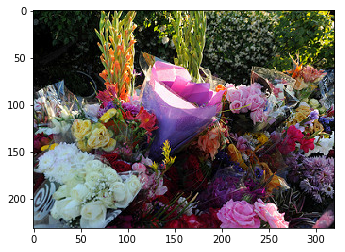

In [101]:
test_img_path = 'flower_photos/roses/10894627425_ec76bbc757_n.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [102]:
del vgg

In [103]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

/home/WORKSPACE/scott.quiring/MachineLearning/DeepLearning/Projects/newCheckout/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s


In [105]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)

In [126]:
      
#saver = tf.train.Saver()
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


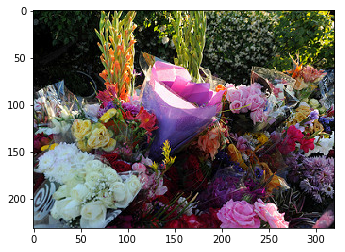

In [127]:
plt.imshow(test_img)

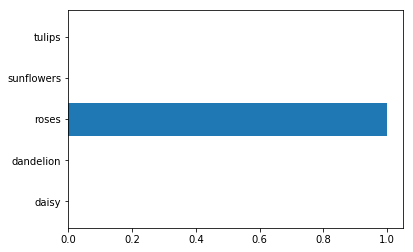

In [129]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), binarizer.classes_)